In [2]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
## read data 
CIP_data = pd.read_csv("CIP_data_encode_prev.csv")
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR',
       'GENDERSP', 'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'REGION', 'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West',
       'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION'],
      dtype='object')


In [64]:
## FOR GRANT WE WANT ALL DATA 
all_data = pd.read_csv("GISP20002019.csv")
total_obs_all_data = all_data["TOTAL"].sum()
print(total_obs_all_data)
all_data.iloc[:, 5:len(all_data.columns)] = all_data.iloc[:, 5:len(all_data.columns)].apply(pd.to_numeric, errors='coerce')


112487


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_82501/37584077.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  all_data.iloc[:, 5:len(all_data.columns)] = all_data.iloc[:, 5:len(all_data.columns)].apply(pd.to_numeric, errors='coerce')


In [53]:
## To get summary stats, use original data 
CIP_data_full = pd.read_csv("CIP_Resistant_disagregated.csv")
print(CIP_data_full.columns)
total_obs = len(CIP_data_full)
print(total_obs)
#####
## initial stats for regional data 
#####
west = ['POR', 'PHX', 'HON', 'SDG', 'SFO', 'ANC', 'SEA', 'DEN', 'LVG', 'ORA', 'LBC', 'SLC', 'LAX']
southwest = ['OKC','MIN', 'ALB', 'DAL']
midwest = ['KCY','CHI', 'PON', 'CIN', 'JAC', 'IND', 'STL','DTR', 'MIL', 'COL', 'CLE']
southeast = ['GRB', 'NOR','WDC','MIA', 'BHM','FBG','ATL', 'RIC']
northeast = ['BUF','BOS', 'CAM', 'NYC', 'BAL', 'PHI']

CIP_data_full['REGION'] = CIP_data_full['CLINIC'].apply(lambda x: 
    'West' if (x in west) else (
        'Southwest' if (x in southwest) else(
            'Midwest' if (x in midwest) else(
                'Southeast' if (x in southeast) else(
                    'Northeast' if (x in northeast) else 'Other'))))) #drug_combinations = ['TetI']



regions = CIP_data_full['REGION'].unique()
regional_average = []
for region in regions:
    regional_data =len(CIP_data_full.loc[CIP_data_full['REGION'] == region])
    regional_average.append({region,(regional_data/total_obs)*100}) 
 
print(regional_average)
#####
## initial stats for gender data
#####

gendersps = CIP_data_full['GENDERSP'].unique()
gendersp_average = []
for gendersp in gendersps:
    gendersp_data =len(CIP_data_full.loc[CIP_data_full['GENDERSP'] == gendersp])
    gendersp_average.append({gendersp,(gendersp_data/total_obs)*100}) 
 
print(gendersp_average)


Index(['Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP', 'Susceptible'], dtype='object')
112487
[{'Southwest', 12.560562553895116}, {'West', 35.42098198013993}, {17.462462328980237, 'Southeast'}, {'Northeast', 11.79602976343933}, {'Midwest', 22.75996337354539}]
[{'MSW', 70.61527109799354}, {22.368807062149404, 'MSM'}, {4.299163458888583, 'MSMW'}, {'Oth/Unk/Missing', 2.7167583809684674}]


In [68]:
### % resistant to CIP 
1 - sum(CIP_data_full["Susceptible"])/total_obs



####
all_resistance_to_CIPR = all_data[['CipR_PenR_TetR', 'CipR_PenI_TetI', 'CipR_TetR_PenI', 'CipR_PenI',
       'CipR_PenR_TetI', 'AziRS_CipR_PenR_TetR', 'CipR_PenR',
       'AziRS_CipR_TetR_PenI', 'CfxRS_CipR_PenR_TetR', 'AziRS_CipR_PenI_TetI',
       'CipR_TetI', 'CipR', 'CipR_TetR', 'CfxRS_CipR_TetR_PenI',
       'AziRS_CipR_PenR_TetI', 'CroRS_CfxRS_CipR_PenR_TetR']].sum(axis = 1) 

print(all_resistance_to_CIPR.sum()/total_obs)
print(all_resistance_to_CIPR.sum())

###14.45%?
### 0.14488785370753954

0.14488785370753954
16298.0


In [ ]:
### Now doing only 2007

In [29]:
## permutation importance on test data 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#train data: 2000 - 2009
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2010 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)

ROC_AUC_neural_network_apparent = metrics.roc_auc_score(y_test, y_predict)



In [17]:
print(ROC_AUC_neural_network_apparent)
perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

0.6109639114786436


Weight,Feature
0.0904 ± 0.0023,PREV_REGION
0.0468 ± 0.0014,MSW
0.0453 ± 0.0008,MSM
0.0370 ± 0.0012,West
0.0243 ± 0.0011,PREV_CLINIC
0.0114 ± 0.0013,DELTA_REGION
0.0114 ± 0.0008,Southeast
0.0110 ± 0.0004,Southwest
0.0080 ± 0.0010,MSMW
0.0072 ± 0.0008,Midwest


In [96]:
PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 100, random_state = 42)
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']
for i in PI.importances_mean.argsort()[::-1]:
    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
            print(f"{feature_names[i]:<8}"
            f"{PI.importances_mean[i]:.3f}"
            f" +/- {PI.importances_std[i]:.3f}")

PREV_CLINIC0.075 +/- 0.001
West    0.022 +/- 0.001
Northeast0.009 +/- 0.001
MSW     0.008 +/- 0.001
Southwest0.007 +/- 0.001
Midwest 0.006 +/- 0.001
Southeast0.006 +/- 0.001
PREV_REGION0.002 +/- 0.001
MSMW    0.001 +/- 0.000
MSM     -0.000 +/- 0.001
Oth/Unk/Missing-0.001 +/- 0.000


In [ ]:
## now do hyperparameter tuning again post PI
space = dict()
space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 10)
space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(4), (6),(8), (12), (13), (14)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha = 1.291549665014884, random_state=10, learning_rate = 'adaptive' )

X = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_REGION']]
y = CIP_data_no_drop['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X, y = oversample.fit_resample(X,y)
model_fit = model_nn.fit(X, y)

search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#Best Score: 0.8012056228019937
#Best Hyperparameters: {'learning_rate': 'constant', 'hidden_layer_sizes': 13, 'alpha': 1.291549665014884, 'activation': 'tanh'}

In [19]:
## now get ROC_AUC based on threshold of 0.5 with non-dropped dataset and resistance being outcome of interest 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

#test data: 2010 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([ 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

#fit model on training data
model_fit = model_nn.fit(X_train, y_train)

#test data
y_predict = model_fit.predict(X_test)

ROC_AUC_nn = metrics.roc_auc_score(y_predict, y_test)


print('ROC_AUC_nn_apparent:', ROC_AUC_nn) 
#ROC_AUC_nn_apparent: 0.6004030461609611

ROC_AUC_nn_apparent: 0.6004030461609611


In [120]:
## permutation importance on test data WITH NEW parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2009
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2010 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)

ROC_AUC_neural_network_apparent = metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_nn_apparent:', ROC_AUC_neural_network_apparent) 

print(ROC_AUC_neural_network_apparent)
perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())


PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 100, random_state = 42)
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']
for i in PI.importances_mean.argsort()[::-1]:
    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
            print(f"{feature_names[i]:<8}"
            f"{PI.importances_mean[i]:.3f}"
            f" +/- {PI.importances_std[i]:.3f}")
#0.6050601090340751

ROC_AUC_nn_apparent: 0.599349287519092
0.599349287519092
PREV_CLINIC0.048 +/- 0.001
MSW     0.010 +/- 0.001
PREV_REGION0.010 +/- 0.001
West    0.008 +/- 0.001
Northeast0.007 +/- 0.001
Southeast0.006 +/- 0.001
Southwest0.004 +/- 0.001
Midwest 0.003 +/- 0.001
MSMW    0.003 +/- 0.000
MSM     0.001 +/- 0.001
Oth/Unk/Missing0.000 +/- 0.000


In [28]:
## what happens to PI if you leave out one of the collinear levels 
## permutation importance on test data WITH NEW parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2009
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2010 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW','Northeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)

ROC_AUC_neural_network_apparent = metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_nn_apparent:', ROC_AUC_neural_network_apparent) 

print(ROC_AUC_neural_network_apparent)
perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())


#PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 100, random_state = 42)
#feature_names = ['MSM','MSMW', 'MSW', 'Northeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']
#for i in PI.importances_mean.argsort()[::-1]:
#    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
#            print(f"{feature_names[i]:<8}"
#            f"{PI.importances_mean[i]:.3f}"
#            f" +/- {PI.importances_std[i]:.3f}")

ROC_AUC_nn_apparent: 0.6049563533971203
0.6049563533971203


Weight,Feature
0.0946 ± 0.0016,PREV_REGION
0.0344 ± 0.0017,PREV_CLINIC
0.0211 ± 0.0011,MSW
0.0191 ± 0.0009,MSM
0.0131 ± 0.0009,DELTA_REGION
0.0098 ± 0.0026,Midwest
0.0017 ± 0.0007,MSMW
0.0008 ± 0.0008,Northeast
-0.0006 ± 0.0006,Southwest
-0.0103 ± 0.0012,West


In [30]:
### now look at response of sensitivity and specificity to classification threshold - non-dropped
### NEW WORST FEATURES - NE and Other
### using split data - do not do bootstrapping
### only using 2011 (presume parameters don't change much?)
##model
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )

#loop setup
#threshold_seq = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
threshold_seq = np.linspace(0,1,101)

#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Southwest', 'Southeast',  'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
#test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
#try sensitivity and specificity for graph
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]

X_test = test_data[['MSM','MSMW', 'MSW', 'Southwest', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

 #1. Create model using all data and get the apparent sensitivity and specificty 

model_fit_train = model_nn.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
#dataframes
sensitivity_test_threshold = []
specificity_test_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:
  #print(threshold)
 
 
  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  # Save results
  sensitivity_test_threshold.append(sensitivity_test)
  specificity_test_threshold.append(specificity_test)


  


101


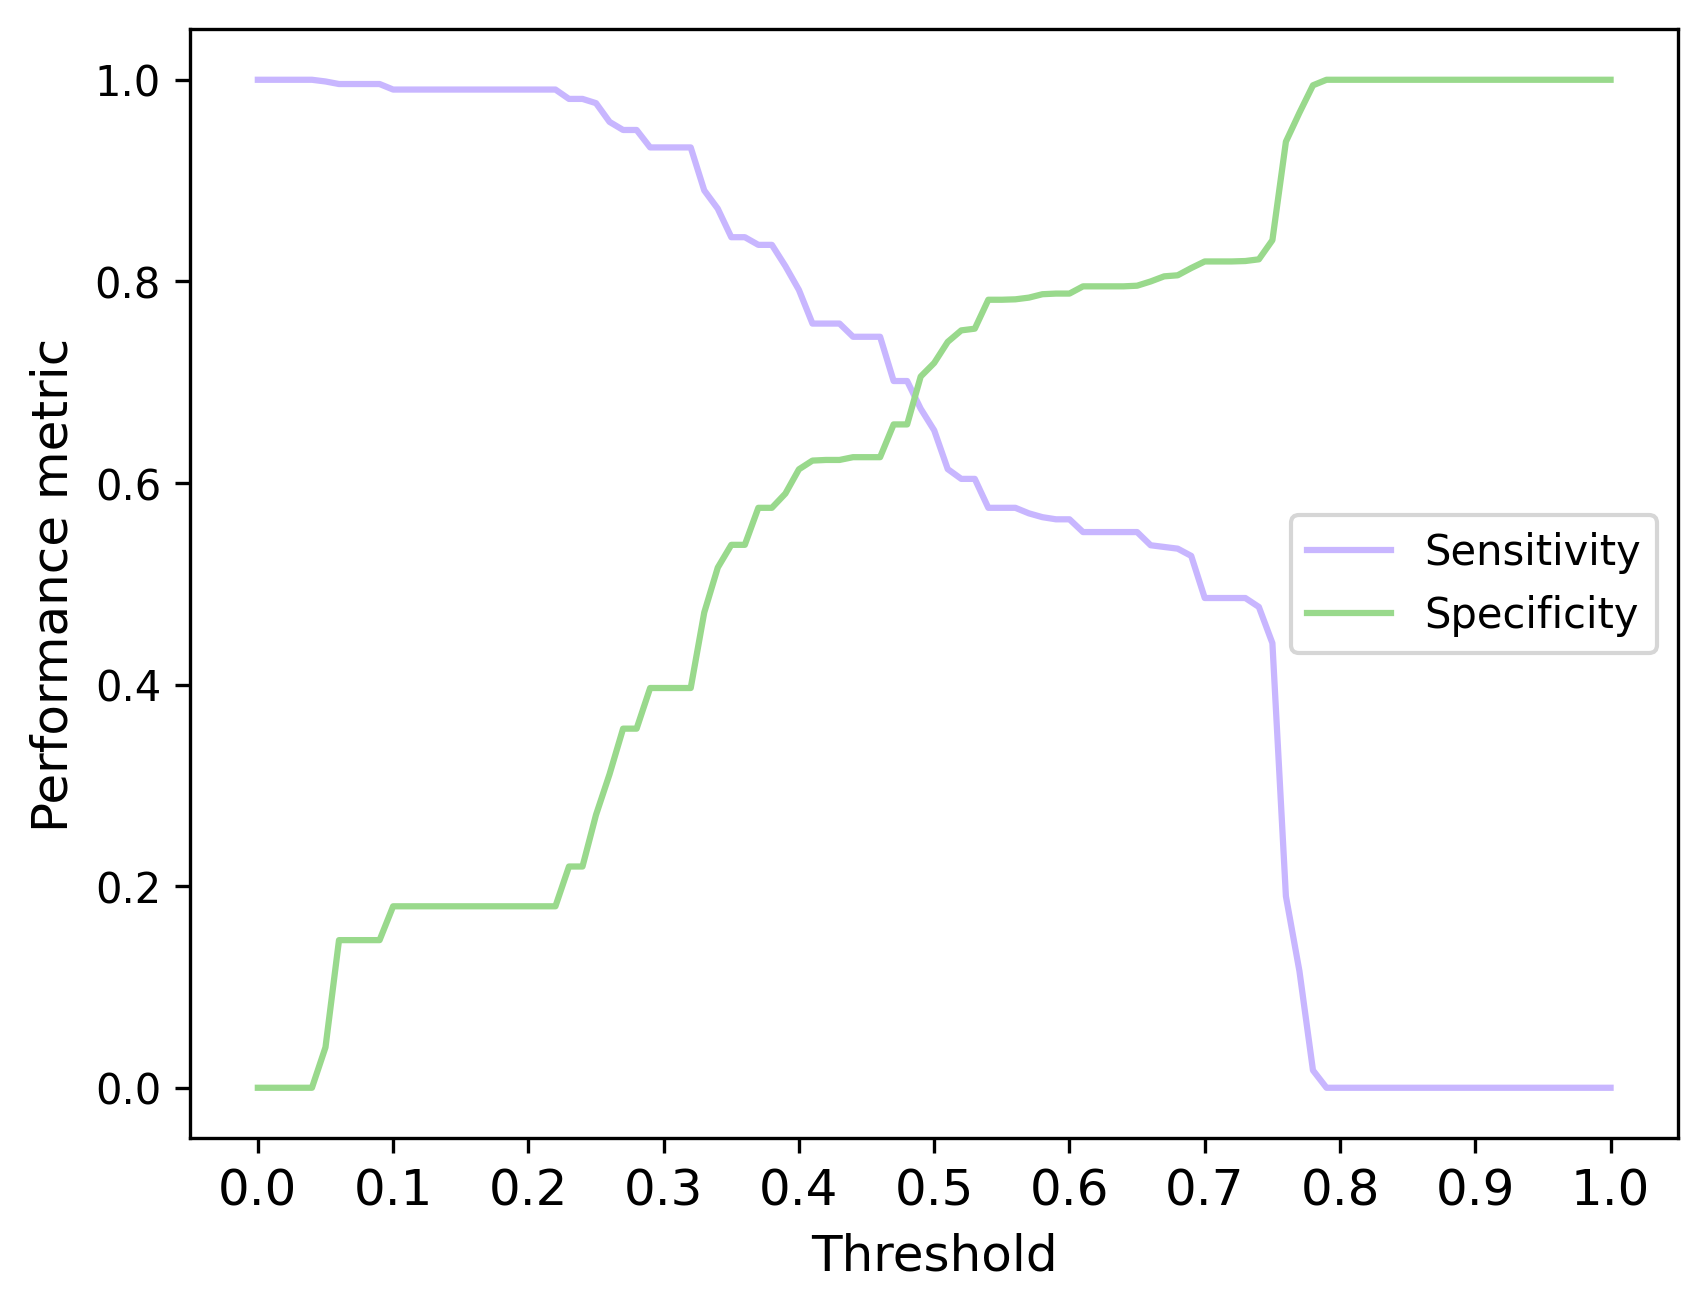

In [24]:
sensitivity_test_threshold = pd.DataFrame(sensitivity_test_threshold)
specificity_test_threshold = pd.DataFrame(specificity_test_threshold)
print(len(sensitivity_test_threshold))
threshold_seq = np.linspace(0,1,101)

plt.plot(threshold_seq, sensitivity_test_threshold, color = "#c8b6ff", label = "Sensitivity")
plt.plot(threshold_seq, specificity_test_threshold, color = "#99d98c", label = "Specificity")
#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Performance metric", fontsize=12)
plt.xticks(np.linspace(0,1,11), fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.legend()

plt.savefig('Sensitivity_specificity_NN_only_2011_dropped_SW_Other.png')

In [25]:
### Get ROC-AUC for the 2011 training dataset w/o SW and Other
##model
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )

#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast',  'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
#test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
#try sensitivity and specificity for graph
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]

X_test = test_data[['MSM','MSMW', 'MSW', 'Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)


model_fit_train = model_nn.fit(X_train, y_train)


  #2. Test model on test data to get test specificity and sensitivity 
threshold = 0.5
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
 
y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

ROC_AUC_neural_network_only_2011_drop_SW_other = metrics.roc_auc_score(y_test, y_predict)
print(ROC_AUC_neural_network_only_2011_drop_SW_other)
#0.6856268467707892

0.6856268467707892


In [144]:
### repeat for different samples ROC-AUC 

n_iterations = 10


ROC_dataframe_all = []

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )

for i in range(n_iterations):
    #Generate new test and train data 
            # train
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
    X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
    y_train = 1 - train_data['Susceptible']

    oversample = RandomOverSampler(sampling_strategy = 0.5)#, random_state=10)
    X_train, y_train = oversample.fit_resample(X_train,y_train)

            # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
    X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
    y_test = 1 - test_data['Susceptible']
    oversample = RandomOverSampler(sampling_strategy = 0.5) #, random_state=10)
    X_test, y_test = oversample.fit_resample(X_test,y_test)

    # Train model on training data - don't need to test on test data 
    model_fit_train = model_nn.fit(X_train, y_train)

    # Permutation importance 

    y_predict = model_nn.predict(X_test)

    ROC_AUC = metrics.roc_auc_score(y_test, y_predict)
    #Save results. 1 = +ve, -1 = -ve 
    ROC_dataframe_all.append(ROC_AUC)


In [149]:
print(ROC_dataframe_all)
print(np.mean(ROC_dataframe_all))
##0.607 with seed = 42
##0.607 with speed = 4
## 0.593 with seed = 10
## 0.6009733839654378 - with random number generator

[0.5942476727150063, 0.614829437119258, 0.6038832829648906, 0.5963185049308142, 0.6068460737066008, 0.5801215936064363, 0.6020432247812937, 0.6154520969033489, 0.5927457048343188, 0.6032462480924099]
0.6009733839654378


In [7]:
#################### Now looking only at 2007, training it on 2000-2006 ####################


### Stats 

all_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007])]

# number of observations
print(len(all_data))
total_obs = len(all_data)
# number of resistant isolants 
print((1 - all_data['Susceptible']).sum())
# % resistance to cipro 
print((1 - all_data['Susceptible']).sum()/len(all_data))




#####
## initial stats for regional data 
#####
west = ['POR', 'PHX', 'HON', 'SDG', 'SFO', 'ANC', 'SEA', 'DEN', 'LVG', 'ORA', 'LBC', 'SLC', 'LAX']
southwest = ['OKC','MIN', 'ALB', 'DAL']
midwest = ['KCY','CHI', 'PON', 'CIN', 'JAC', 'IND', 'STL','DTR', 'MIL', 'COL', 'CLE']
southeast = ['GRB', 'NOR','WDC','MIA', 'BHM','FBG','ATL', 'RIC']
northeast = ['BUF','BOS', 'CAM', 'NYC', 'BAL', 'PHI']

all_data['REGION'] = all_data['CLINIC'].apply(lambda x: 
    'West' if (x in west) else (
        'Southwest' if (x in southwest) else(
            'Midwest' if (x in midwest) else(
                'Southeast' if (x in southeast) else(
                    'Northeast' if (x in northeast) else 'Other'))))) #drug_combinations = ['TetI']



regions = all_data["REGION"].unique()
reistance_by_region = []
#reistance_by_year_all = pd.DataFrame()
for region in regions:
    CIP_data_region = all_data.loc[all_data['REGION'] == region]

    #CIP_data_region_year = CIP_data_region.loc[CIP_data_region['YEAR'] == 2007]

    reistance_by_region.append(1 - CIP_data_region["Susceptible"].sum()/len(CIP_data_region))
print(reistance_by_region) 
print(regions) 
#####
## initial stats for gender data
#####

genders = all_data["GENDERSP"].unique()
resistance_by_gender = []
#reistance_by_year_all = pd.DataFrame()
for gender in genders:
    CIP_data_gender = all_data.loc[all_data['GENDERSP'] == gender]


    resistance_by_gender.append(1 - CIP_data_gender["Susceptible"].sum()/len(CIP_data_gender))
print(resistance_by_gender) 
print(genders) 




47409
3184
0.06716024383555864
[0.034680337756332946, 0.13193481276005548, 0.032567503552818566, 0.05806190572526804, 0.010807059290105059]
['Southwest' 'West' 'Southeast' 'Northeast' 'Midwest']
[0.032785540455552264, 0.2247175901022055, 0.1606475716064757, 0.031180400890868598]
['MSW' 'MSM' 'MSMW' 'Oth/Unk/Missing']


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_3203/3764487148.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['REGION'] = all_data['CLINIC'].apply(lambda x:


In [11]:
### modelling with 2000 - 2006 as training set 


model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2006
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2007 ONLY 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2007])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)




In [12]:
## hyperparameter tuning round 1
space = dict()

space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 10)
space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(12), (13), (14)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=10)
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =  1.29, random_state=10, learning_rate = 'adaptive' )


search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
#Best Hyperparameters: {'learning_rate': 'adaptive', 'hidden_layer_sizes': 12, 'alpha': 1.291549665014884, 'activation': 'tanh'}

Best Score: 0.9034704564189928
Best Hyperparameters: {'learning_rate': 'adaptive', 'hidden_layer_sizes': 12, 'alpha': 1.291549665014884, 'activation': 'tanh'}


In [16]:
## feature selection 

### Permutation importance w/ hyperparameters and training dataset 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#train data: 2000 - 2010
model_fit_train = model_nn.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
ROC_AUC_neural_network = metrics.roc_auc_score(y_test, y_predict)

#print('ROC_AUC_nn:', ROC_AUC_neural_network) 

perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())


#important_features = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'Midwest','PREV_REGION', 'PREV_CLINIC']

Weight,Feature
0.1195 ± 0.0115,PREV_REGION
0.1080 ± 0.0059,PREV_CLINIC
0.0952 ± 0.0049,MSW
0.0234 ± 0.0020,MSM
0.0187 ± 0.0064,Southwest
0.0119 ± 0.0041,Midwest
0.0101 ± 0.0016,MSMW
0.0074 ± 0.0045,Southeast
0.0041 ± 0.0043,Northeast
0.0025 ± 0.0022,Oth/Unk/Missing


In [17]:
## hyperparameter tuning round 2
# new test and training data 
important_features = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'Midwest','PREV_REGION', 'PREV_CLINIC']
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006])]
X_train = train_data[important_features]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2007 ONLY 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2007])]
X_test = test_data[important_features]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)


# tuning
pace = dict()

space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 10)
space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(12), (13), (14)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=10)
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =  1.29, random_state=10, learning_rate = 'adaptive' )


search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
#Best Hyperparameters: {'learning_rate': 'adaptive', 'hidden_layer_sizes': 14, 'alpha': 0.2782559402207124, 'activation': 'relu'}

Best Score: 0.9014259240847333
Best Hyperparameters: {'learning_rate': 'adaptive', 'hidden_layer_sizes': 14, 'alpha': 0.2782559402207124, 'activation': 'relu'}


In [19]:
## roAUC for final model 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'relu', max_iter = 3000 ,hidden_layer_sizes= 14, alpha =0.2782559402207124, random_state=10, learning_rate = 'adaptive' )
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006])]
X_train = train_data[important_features]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2007 ONLY 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2007])]
X_test = test_data[important_features]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)


ROC_AUC_neural_network = metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_nn:', ROC_AUC_neural_network) 

ROC_AUC_nn: 0.6781946072684641


In [42]:
def effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prevalence):

    get_effective_threshold = []
    incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 
    sensitivity_test_threshold = []
    specificity_test_threshold = []

    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )

        sensitivity_test_threshold.append(sensitivity_test*100)
        specificity_test_threshold.append(specificity_test*100)
        get_effective_threshold.append((sensitivity_test * cipro_R_prevalence + (1 -  cipro_R_prevalence))*100) #q_p
        incorrectly_get_X_threshold.append(((1 - cipro_R_prevalence) * (1 - specificity_test))*100) #c_p"
    return(sensitivity_test_threshold, specificity_test_threshold, get_effective_threshold, incorrectly_get_X_threshold)

In [109]:
## Get sensitivity, specificity, effective and unnecessary treatment by threshold 

plt.rcParams["figure.figsize"] = (7,5.5)

threshold_seq = np.linspace(0,1,1001)

cipro_prevalence_2007 = ((1 - test_data['Susceptible']).sum())/len(test_data['Susceptible'])

sensitivity_test_threshold, specificity_test_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq,  y_predict_proba, y_test, cipro_R_prevalence = cipro_prevalence_2007)

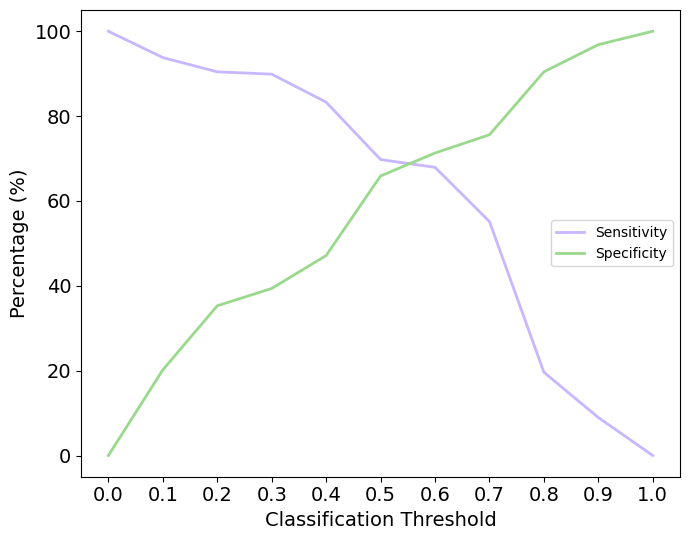

In [106]:
### Plot 1: Sensitivity and specificity by threshold 
plt.plot(threshold_seq, sensitivity_test_threshold, color = "#c8b6ff", label = "Sensitivity", linewidth = 2)
plt.plot(threshold_seq, specificity_test_threshold, color = "#99d98c", label = "Specificity", linewidth = 2)

plt.xlabel("Classification Threshold", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(np.linspace(0,1,11), fontsize=14)
plt.yticks(np.linspace(0,100,6), fontsize=14)

plt.legend()
plt.tight_layout()
plt.rcParams["figure.figsize"] = (4.5,5)
plt.savefig('Graphs/Percentage_specificity_sensitivity_by_threshold_nn_2007.png')

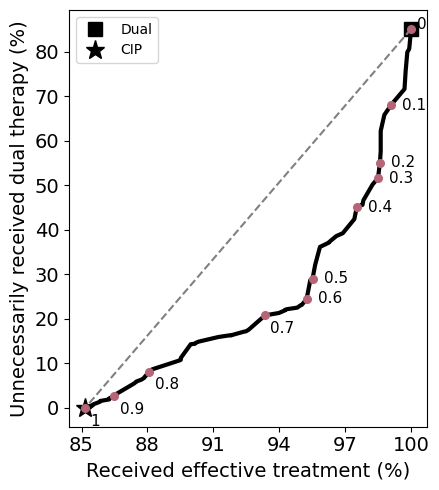

In [120]:
### Plot 2: Necessary vs unnecessary 
### Plotting overall proportion receiving effective and unnecessary treatment with all training data 

plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)

plt.xlabel(r"Received effective treatment (%)", fontsize=14)
plt.ylabel("Unnecessarily received dual therapy (%)", fontsize=14)
plt.xticks(np.linspace(85,100,6), fontsize=14)
plt.yticks(np.linspace(0,100,11), fontsize=14)


plt.plot(100, 100 - cipro_prevalence_2007*100, marker='s', ls='none', ms=10, color = "black", label = "Dual")
plt.plot((100-cipro_prevalence_2007*100), 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
plt.plot([100, 100-cipro_prevalence_2007*100], [100-cipro_prevalence_2007*100, 0], color = "#808080", linestyle="--")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,100,200,300,400,500,600,700,800,900,1000]
x = 0
for index in indices:
    plt.plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
    if get_effective_threshold[index] > 99.6:
        plt.text(get_effective_threshold[index] + 0.27, incorrectly_get_X_threshold[index] - 0.1, text_for_graph[x], size = 11)
    elif (get_effective_threshold[index] > 95) & (get_effective_threshold[index] < 99.6):
        plt.text(get_effective_threshold[index] + 0.5, incorrectly_get_X_threshold[index] - 1, text_for_graph[x], size = 11)
    else:
        plt.text(get_effective_threshold[index] + 0.25, incorrectly_get_X_threshold[index] - 4, text_for_graph[x], size = 11)
    x = x+1
plt.tight_layout()
plt.rcParams["figure.figsize"] = (4.5,5)

#plt.savefig('Graphs/Percent_effective_unnecessary_nn_2007.png', dpi = 600)
